# Deep Learning

Deep learning describes a vast array of machine learning models that allow models to learn the best *representation* of input data. The models work reasonably well with raw input data, training models that not only perform well, but also allow prediction based on raw inputs. 

This can be applied for a variety of applications in networking, including malware are Denial of Service attack detection (as below). In many cases, as we will see in this exercise, the deep learning models perform no better than standard machine learning models.

This hands on re-implements the detection process from the following paper:
Doshi, Rohan, Noah Apthorpe, and Nick Feamster. "[Machine learning ddos detection for consumer internet of things devices](https://arxiv.org/abs/1804.04159)." 2018 IEEE Security and Privacy Workshops (SPW). IEEE, 2018.

First, we will load all of the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import math

# Plotting and Utils
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


# ML Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# Deep Learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

## Part 1: Data Preparation

### Normal Traffic
We collect normal traffic from a simulated consumer IoT network over the course of 10 minutes. There are three devices: a security camera, a blood pressure monitor, and a smart outlet. There is also an Android phone to control these devices; the phone also serves as a wif link for uploading data to the internet, as is the case for the bluetooth-connected blood presure monitor.

In [2]:
normal = pd.read_csv('data/normal-iot.csv.gz')
normal['Label'] = 0 # 0 is normal traffic, 1 is attack traffic

This traffic trace has device traffic from three different devices:
* a WeMo Smart switch
* a Yi Home Camera
* an Android Phone

This phone, although not an IoT device, controls three diffferent IoT devices on the network:
1. WeMo Smart Switch: turns switch on/off
2. Yi Home Camera: live video streaming 
3. Withings Blood Pressure Monitor: connect to device via bluetooth and 
   uploads medical data to cloud; the phone acts just as a wifi link

In [3]:
# WeMo Smart Switch: a Wifi connected outlet that is controlled
# by a phone via the cloud.
normal_switch = normal[normal['Source'] == '172.24.1.81']

# Yi Home Camera: a Wifi enabled home security camera that supports
# control and streaming from your phone via the cloud.
normal_camera = normal[normal['Source'] == '172.24.1.107']

# Android Phone. 
# Phones behave quite differently from other IoT devices. They connect with
# more endpoints and are more versatile in the types of protocols they use.
normal_phone = normal[normal['Source'] == '172.24.1.63']

### Attack Traffic
We simulate the three most common denial of service of attacks that an IoT device infected with the Mirai botnet
would execute. Using a Linux VM and a Raspberry Pi connected to a router running on another Raspberry Pi, we generates attack traffic across the three following attack vectors:
1. HTTP GET Flood - 2 miuntes; simulated with Goldeneye on Linux VM attacking Google.com
2. TCP SYN Flood - 5 minutes; simulated with hping3 on Raspberry Pi attacking Linux VM on LAN
3. UDP Flood - 2.5 minutes; simulated with hping3 on Raspberry Pi attacking Linux VM on LAN

We preprocess the attack traffic as if the attacks are coming from the devices in the simulated IoT network. We make a variety of assumptions in order to overlay the attack traffic on the three hosts from the normal traffic. Each of the three Wifi connected devices is infected with the botnet and will execute each of the four attacks once within a 10 minute internal in a random order for a random time period of around 100 seconds each; this way, at any given time, there is a 50% probability that an attack is underway ( (100*3)/600 = .5). During an attack period, each device will be able to simultaneously send attack and normal traffic. The distribution of attacks between devices is independent of each other. We set the target of all attacks to an arbitrary IP on the internet: 8.8.8.8. (e.g. google.com) at a fixed port (80 for http attack, 443 for tcp/udp attack). 

**Note: We assume that we cannot leverage the destination IP address for classification purposes because we do not want to maintain state at the router. This is a KEY advantage of using ML for flow-based anomaly detection. Otherwise, we could consume memory at the router and count the number of connections to each external IP address; if above threshold, we could identify DOS attack.

In [32]:
# Load attack traffic
attack_http = pd.read_csv('data/http_flood.csv.gz')
attack_tcp = pd.read_csv('data/tcp_flood.csv.gz')
attack_udp = pd.read_csv('data/udp_flood.csv.gz')

# Add Label, 0 is normal traffic, 1 is attack traffic
attack_http['Label'] = 1
attack_tcp['Label'] = 1
attack_udp['Label'] = 1

# clean the attack data by isolating the source IP address
# only consider look at DOS attack originating from within the network.
attack_http = attack_http[ (attack_http['Source'] == '172.24.1.67') & (attack_http['Destination'] == '172.217.11.36')]
attack_tcp = attack_tcp[ (attack_tcp['Source'] == '172.24.1.108') & (attack_tcp['Destination'] == '172.24.1.67') ]
attack_udp = attack_udp[ (attack_udp['Source'] == '172.24.1.108') & (attack_udp['Destination'] == '172.24.1.67') ]

# set destination IP of attacks
attack_http['Destination'] = '8.8.8.8'
attack_tcp['Destination'] = '8.8.8.8'
attack_udp['Destination'] = '8.8.8.8'

# set destination ports of attacks
attack_http['Dst_port'] = 80
attack_tcp['Dst_port'] = 443
attack_udp['Dst_port'] = 443

In [30]:
attack_tcp.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info,Src_port,Dst_port,Delta_time,Label
1,2,0.017480,172.24.1.108,8.8.8.8,SSH,122,Server: Encrypted packet (len=56),22.0,443,0.017480,1
4,5,0.031885,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.001397,1
13,14,0.737961,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.027162,1
15,16,0.738272,172.24.1.108,8.8.8.8,TCP,66,22 > 50953 [ACK] Seq=137 Ack=201 Win=294 Len=0...,22.0,443,0.000089,1
16,17,0.738418,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.000146,1
17,18,0.738984,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.000566,1
21,22,0.839763,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.040248,1
24,25,0.942004,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.058905,1
27,28,0.962898,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.000095,1
31,32,1.143729,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.009299,1


#### Device 1 (WeMo Smart Switch) Attack Profile  

Attack 1: HTTP GET Flood, 90 seconds, 20-110 sec  
Attack 2: TCP SYN Flood, 110 seconds, 300-410 sec  
Attack 3: UDP Flood, 100 seconds, 475-575 sec  

In [8]:
pd.options.mode.chained_assignment = None

# attack 1
attack_http_switch = attack_http[attack_http['Time'] <= 90]
attack_http_switch.loc[:,'Time'] = attack_http_switch.loc[:,'Time'] + 20
attack_http_switch.loc[:,'Source'] = '172.24.1.81'

# attack 2
attack_tcp_switch = attack_tcp[attack_tcp['Time'] <= 110]
attack_tcp_switch.loc[:,'Time'] = attack_tcp_switch.loc[:,'Time'] + 300
attack_tcp_switch.loc[:,'Source'] = '172.24.1.81'

# attack 3
attack_udp_switch = attack_udp[attack_udp['Time'] <= 100]
attack_udp_switch.loc[:,'Time'] = attack_udp_switch.loc[:,'Time'] + 475
attack_udp_switch.loc[:,'Source'] = '172.24.1.81'

#### Device 2 (YI Home Camera) Attack Profile

Because the device performs three attacks at three different times in the trace, we subdivide the trace according to time interval to get dataframes with the specific attacks.

Attack 1: TCP SYN Flood, 80 seconds, 25-107 sec  
Attack 2: HTTP GET Flood, 100 seconds, 310-410 sec  
Attack 3: UDP Flood, 120 seconds, 450-570 sec  

In [9]:
# attack 1
attack_tcp_camera = attack_tcp[attack_tcp['Time'] <= 80]
attack_tcp_camera.loc[:,'Time'] = attack_tcp_camera['Time'] + 25
attack_tcp_camera.loc[:,'Source'] = '172.24.1.107'

# attack 2
attack_http_camera = attack_http[attack_http['Time'] <= 100]
attack_http_camera.loc[:,'Time'] = attack_http_camera['Time'] + 310
attack_http_camera.loc[:,'Source'] = '172.24.1.107'

# attack 3
attack_udp_camera = attack_udp[attack_udp['Time'] <= 120]
attack_udp_camera.loc[:,'Time'] = attack_udp_camera['Time'] + 450
attack_udp_camera.loc[:,'Source'] = '172.24.1.107'

#### Device 3 (Android Phone) Attack Profile  

Because the device performs three attacks at three different times in the trace, we subdivide the trace according to time interval to get dataframes with the specific attacks.

Attack 1: UDP Flood, 105 seconds, 5-120 sec  
Attack 2: TCP SYN Flood, 80 seconds, 240-320 sec  
Attack 3: HTPP GET Flood, 115 seconds, 420-535 sec  

In [10]:
# attack 1
attack_udp_phone = attack_udp[attack_udp['Time'] <= 105]
attack_udp_phone.loc[:,'Time'] = attack_udp_phone['Time'] + 5
attack_udp_phone.loc[:,'Source'] = '172.24.1.63'

# attack 2
attack_tcp_phone = attack_tcp[attack_tcp['Time'] <= 80]
attack_tcp_phone.loc[:,'Time'] = attack_tcp_phone['Time'] + 240
attack_tcp_phone.loc[:,'Source'] = '172.24.1.63'

# attack 3
attack_http_phone = attack_http[attack_http['Time'] <= 115]
attack_http_phone.loc[:,'Time'] = attack_http_phone['Time'] + 420
attack_http_phone.loc[:,'Source'] = '172.24.1.63'

## Step 2: Generate Features and Labels

The next step is to generate features and labels (1=attack, 0=normal) for each device.

**Note**: This approach assumes a constant set of features that is not protocol-specific. 

#### WeMo Switch Feature Generation

In [15]:
# merge attack and normal traffic
switch_data = pd.concat([normal_switch, attack_http_switch, attack_tcp_switch, attack_udp_switch])
camera_data = pd.concat([normal_camera, attack_http_camera, attack_tcp_camera, attack_udp_camera])
phone_data = pd.concat([normal_phone, attack_http_phone, attack_tcp_phone, attack_udp_phone])

In [16]:
# generate device specific temporal features
def generate_device_temporal_features_and_labels(data):
    # map each row to a 10 second time bin
    data['TimeBin'] = data['Time']
    data['TimeBin'] = (data['TimeBin']/10.0)
    data['TimeBin'] = data['TimeBin'].apply(np.floor)
    group = data.groupby(['TimeBin'])
    group_features = group.apply(group_feature_extractor)
    group_features['device_timebin_delta_num_dest'] = group_features['device_timebin_num_dest'].diff(periods=1)
    group_features['device_timebin_delta_num_dest'] = group_features['device_timebin_delta_num_dest'].fillna(0)

    data = data.merge(group_features, left_on='TimeBin', right_index=True)
    return data
    
def group_feature_extractor(g):
    ten_sec_traffic = (g['Length']).sum() / 10
    ten_sec_num_host = len(set(g['Destination']))
    return pd.Series([ten_sec_traffic, ten_sec_num_host], index = 
                     ['device_timebin_bandwidth', 'device_timebin_num_dest'])

In [17]:
switch_data = generate_device_temporal_features_and_labels(switch_data)
camera_data = generate_device_temporal_features_and_labels(camera_data)
phone_data = generate_device_temporal_features_and_labels(phone_data)

In [18]:
switch_data

,No.,Time,Source,Destination,Protocol,Length,Info,Src_port,Dst_port,Delta_time,Label,TimeBin,device_timebin_bandwidth,device_timebin_num_dest,device_timebin_delta_num_dest
83,84,18.604856,172.24.1.81,172.24.1.1,ICMP,98,"Echo (ping) request id=0x7b08, seq=0/0, ttl=6...",NaN,NaN,1.916105,0,1.0,8888.0,2.0,0.0
85,86,18.683087,172.24.1.81,172.24.1.1,DNS,76,Standard query 0x001d A insight.lswf.net,3076.0,53.0,0.078088,0,1.0,8888.0,2.0,0.0
87,88,18.695402,172.24.1.81,23.21.145.73,TCP,66,4925 > 443 [SYN] Seq=0 Win=5840 Len=0 MSS=1460...,4925.0,443.0,0.002567,0,1.0,8888.0,2.0,0.0
89,90,18.704376,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=1 Ack=1 Win=5840 Len=0,4925.0,443.0,0.001640,0,1.0,8888.0,2.0,0.0
90,91,18.740927,172.24.1.81,23.21.145.73,TLSv1,175,Client Hello,4925.0,443.0,0.036551,0,1.0,8888.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11167,11168,499.982123,172.24.1.81,8.8.8.8,UDP,42,52876 > 0 Len=0,52876.0,443.0,0.003938,1,49.0,17039.4,1.0,0.0
11168,11169,499.986259,172.24.1.81,8.8.8.8,UDP,42,52920 > 0 Len=0,52920.0,443.0,0.004136,1,49.0,17039.4,1.0,0.0
11169,11170,499.989738,172.24.1.81,8.8.8.8,UDP,42,52957 > 0 Len=0,52957.0,443.0,0.003479,1,49.0,17039.4,1.0,0.0
11170,11171,499.996349,172.24.1.81,8.8.8.8,UDP,42,53028 > 0 Len=0,53028.0,443.0,0.006611,1,49.0,17039.4,1.0,0.0


In [19]:
def generate_features_and_labels(data):
    data.sort_values(by=['Time'],  ascending=[1]) # sort all traffic by time
    data = data.dropna() # drop rows with either missing source or destination ports
    data = data.reset_index(drop=True)
    
    # GENERATE FEATURES
    features = data.copy(deep=True)

    # velocity, acceleration, and jerk in time in between successive packets
    features['dT'] = features['Time'] - features['Time'].shift(3)
    features['dT2'] = features['dT'] - features['dT'].shift(3)
    features['dT3'] = features['dT2'] - features['dT2'].shift(3)
    features = features.fillna(0) # fill offset rows with zeros #### FIX THIS - not working...

    # one hot encoding of common protocols: HTTP: TCP, UDP, and OTHER
    features['is_HTTP'] = 0
    features.loc[ ( (features['Protocol'] == 'HTTP') | (features['Protocol'] == 'HTTP/XML') ), ['is_HTTP']] = 1

    features['is_TCP'] = 0
    features.loc[features['Protocol'] == 'TCP', ['is_TCP']] = 1

    features['is_UDP'] = 0
    features.loc[features['Protocol'] == 'UDP', ['is_UDP']] = 1

    features['is_OTHER'] = 0
    features.loc[(
                    (features['Protocol'] != 'HTTP') &
                    (features['Protocol'] != 'HTTP/XML') &
                    (features['Protocol'] != 'TCP') &
                    (features['Protocol'] != 'UDP') 
                ), ['is_OTHER']] = 1

    # generate time-series features based on last most recent 10,000 packets:
    # 1. percent of traffic to the given destination IP
    # 2. percent of traffic to the given destination port
    # 3. Devices 
    # TODO
    
    # GENERATE LABELS
    labels = features['Label']

    del features['No.']
    del features['Time']
    del features['Source']
    del features['Destination']
    del features['Protocol']
    del features['Info']
    del features['Src_port']
    del features['Dst_port']
    del features['Delta_time']
    del features['Label']
    del features['TimeBin']
    
    return (features, labels)

In [20]:
# generate 
switch_features, switch_labels = generate_features_and_labels(switch_data)
camera_features, camera_labels = generate_features_and_labels(camera_data)
phone_features, phone_labels = generate_features_and_labels(phone_data)

In [21]:
all_features = pd.concat([switch_features, camera_features, phone_features])
all_labels = pd.concat([switch_labels, camera_labels, phone_labels])

## Step 3: Normalize Data

The next step is to normalize the data, by subtracting the mean and dividing by the standard deviation.

In [22]:
# rescale numerical columns to standard normal
numerical = all_features.iloc[:, [0,1,2,3,4,5,6]]
numerical = (numerical - np.mean(numerical, axis=0)) / np.std(numerical, axis=0)
# rescale categorical columns from [0,1] to [-1,1]
categorical = all_features.iloc[:, [7,8,9,10]]
categorical = categorical*2-1
# recombine data
all_features = pd.concat([numerical, categorical], axis=1)

In [23]:
all_features

,Length,device_timebin_bandwidth,device_timebin_num_dest,device_timebin_delta_num_dest,dT,dT2,dT3,is_HTTP,is_TCP,is_UDP,is_OTHER
0,-0.081194,-1.208889,-0.498237,-0.059281,-0.002757,0.000016,-0.000009,-1,-1,-1,1
1,-0.139957,-1.208889,-0.498237,-0.059281,-0.002757,0.000016,-0.000009,-1,1,-1,-1
2,-0.210472,-1.208889,-0.498237,-0.059281,-0.002757,0.000016,-0.000009,-1,1,-1,-1
3,0.500557,-1.208889,-0.498237,-0.059281,0.026265,0.000016,-0.000009,-1,-1,-1,1
4,-0.210472,-1.208889,-0.498237,-0.059281,0.025148,0.000016,-0.000009,-1,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
156312,-0.280987,-0.931983,-0.842540,-1.497128,-0.002218,-0.001410,0.004253,-1,-1,1,-1
156313,-0.280987,-0.931983,-0.842540,-1.497128,-0.002219,-0.000391,0.006012,-1,-1,1,-1
156314,-0.280987,-0.931983,-0.842540,-1.497128,-0.001946,0.000022,0.006504,-1,-1,1,-1
156315,-0.280987,-0.931983,-0.842540,-1.497128,-0.002132,0.000078,0.000853,-1,-1,1,-1


In [24]:
# get subset of features (non-temporal)
packet_features = all_features.iloc[:,[0,4,5,6,7,8,9,10]]
packet_features

,Length,dT,dT2,dT3,is_HTTP,is_TCP,is_UDP,is_OTHER
0,-0.081194,-0.002757,0.000016,-0.000009,-1,-1,-1,1
1,-0.139957,-0.002757,0.000016,-0.000009,-1,1,-1,-1
2,-0.210472,-0.002757,0.000016,-0.000009,-1,1,-1,-1
3,0.500557,0.026265,0.000016,-0.000009,-1,-1,-1,1
4,-0.210472,0.025148,0.000016,-0.000009,-1,1,-1,-1
...,...,...,...,...,...,...,...,...
156312,-0.280987,-0.002218,-0.001410,0.004253,-1,-1,1,-1
156313,-0.280987,-0.002219,-0.000391,0.006012,-1,-1,1,-1
156314,-0.280987,-0.001946,0.000022,0.006504,-1,-1,1,-1
156315,-0.280987,-0.002132,0.000078,0.000853,-1,-1,1,-1


## Step 4: Train and Test Neural Net

Finally we can train and test the neural net.

Below we have giving an example neural net. 

**To do**:
1. Add some timing code below to capture the time taken for training and testing of this neural net.
2. (Optional) Explore the architecture of the neural net below. Change the architecture of this neural net to see how different architectures affect training time and performance.

In [26]:
def train_test(data, labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.15)   

    model = Sequential()
    model.add(Dense(11, activation='relu', input_dim=data.shape[1]))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=100, batch_size=32)
    y_predict = np.round(model.predict(x_test, batch_size=128))
    
    # Analyze
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predict)
    error = zero_one_loss(y_test, y_predict,)
    accuracy = 1 - error

    print("Normal Precision: " + str(precision[0]))
    print("Attack Precision: " + str(precision[1]))
    print("Normal Recall: " + str(recall[0])) 
    print("Attack Recall: " + str(recall[1])) 
    print("Normal F1: " + str(f1[0]))
    print("Attack F1: " + str(f1[1]))
    print("Error " + str(error))
    print("Accuracy " + str(accuracy))

    # confusion matrix    
    plt.figure()
    classes = ['Normal', 'Attack']
    cm = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [23]:
train_test(all_features.values, all_labels)

Epoch 1/100
13065/13065 [==============================] - 15s 1ms/step - loss: 0.0409 - accuracy: 0.9907
Epoch 2/100
13065/13065 [==============================] - 15s 1ms/step - loss: 0.0283 - accuracy: 0.9948
Epoch 3/100
13065/13065 [==============================] - 15s 1ms/step - loss: 0.0252 - accuracy: 0.9948
Epoch 4/100
13065/13065 [==============================] - 15s 1ms/step - loss: 0.0239 - accuracy: 0.9948
Epoch 5/100
13065/13065 [==============================] - 14s 1ms/step - loss: 0.0240 - accuracy: 0.9951
Epoch 6/100
13065/13065 [==============================] - 15s 1ms/step - loss: 0.0214 - accuracy: 0.9952
Epoch 7/100
13065/13065 [==============================] - 15s 1ms/step - loss: 0.0206 - accuracy: 0.9951
Epoch 8/100
13065/13065 [==============================] - 15s 1ms/step - loss: 0.0218 - accuracy: 0.9952
Epoch 9/100
13065/13065 [==============================] - 14s 1ms/step - loss: 0.0222 - accuracy: 0.9951
Epoch 10/100
13065/13065 [====================

KeyboardInterrupt: 

## Step 5: Compare Against Other Machine Learning Models

We can compare the results above against other ML models.

To validate our data, we split the samples into 10 folds, a standard practice for binary classification tasks.
To get a general sense of how each of the classifiers perform, we iteratively train on 9 of the folds (after 
finetuning) and test on the one fold that is withheld. We average the performance across the 10 tests to compensate
for the possibility of overfitting when evaluating our classifiers. 

The example below trains and tests on the following:
* k-nearest neighbors
* linear SVM
* decision tree
* random forest

**To do**:
1. Add some timing code below to capture the time taken for training and testing of this neural net.


In [27]:

# sigmoid function for normalizing values between 0 and 1
def sig(x):
    return 1/(1+np.exp(-x))

# classifies the model on training data and returns zero-one loss on test data
def classify(model, x_train, x_test, y_train, y_test):
    classifier = model
    if classifier.__class__.__name__ == "MultinomialNB":
        classifier.fit(sig(x_train),y_train)
    else:
        classifier.fit(x_train,y_train)
    y_predict = classifier.predict(x_test)
    
    # ANALYSIS: 
    print("==================================")
    print(classifier.__class__.__name__ + ":")
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predict)
    error = zero_one_loss(y_test, y_predict,)
    accuracy = 1 - error
    
    print("Normal Precision: " + str(precision[0]))
    print("Attack Precision: " + str(precision[1]))
    print("Normal Recall: " + str(recall[0])) 
    print("Attack Recall: " + str(recall[1])) 
    print("Normal F1: " + str(f1[0]))
    print("Attack F1: " + str(f1[1]))
    print("Error " + str(error))
    print("Accuracy " + str(accuracy))
    
    # confusion matrix    
    plt.figure()
    classes = ['Normal', 'Attack']
    cm = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # print feature importance
    if classifier.__class__.__name__ == "RandomForestClassifier":
        print("feature importance:" )
        feature_names = ["Length", "dT", "dT2", "dT3", "is_HTTP", "is_TCP", "is_UDP", "is_OTHER"]
        feat_imp = dict(zip(feature_names, classifier.feature_importances_))
        for feature in sorted(feat_imp.items(), key=lambda x: x[1], reverse=True):
            print(feature)
    
def run_classification(data, labels): 
    model_error = [0, 0, 0, 0, 0]
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.15)    

    # Evaluate five standard classifiers. 
    classify(KNeighborsClassifier(), x_train, x_test, y_train, y_test)
    classify(LinearSVC(), x_train, x_test, y_train, y_test)
    classify(DecisionTreeClassifier(), x_train, x_test, y_train, y_test)
    classify(RandomForestClassifier(), x_train, x_test, y_train, y_test)
    
    print("*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)")

KNeighborsClassifier:
Normal Precision: 0.998278088678433
Attack Precision: 0.9994358699897299
Normal Recall: 0.9916613213598461
Attack Recall: 0.9998842291105902
Normal F1: 0.9949587042797383
Attack F1: 0.9996599992765942
Error 0.0006370376394366772
Accuracy 0.9993629623605633


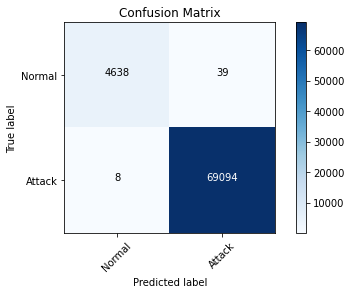

LinearSVC:
Normal Precision: 0.9938423645320197
Attack Precision: 0.9907916063053113
Normal Recall: 0.8627325208466966
Attack Recall: 0.9996382159705942
Normal F1: 0.9236580061806112
Attack F1: 0.9951952514389034
Error 0.009040512883069729
Accuracy 0.9909594871169303


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


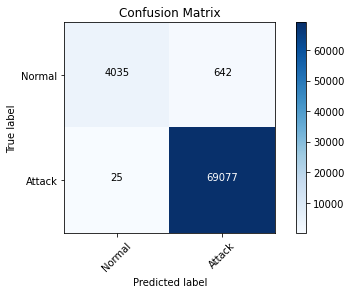

DecisionTreeClassifier:
Normal Precision: 0.9965679965679966
Attack Precision: 0.9995514851628399
Normal Recall: 0.9933718195424417
Attack Recall: 0.9997684582211803
Normal F1: 0.994967341257094
Attack F1: 0.9996599599186798
Error 0.0006370376394366772
Accuracy 0.9993629623605633


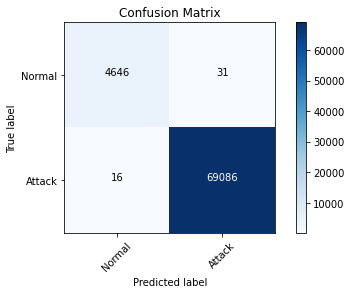

RandomForestClassifier:
Normal Precision: 1.0
Attack Precision: 0.9997540473675834
Normal Recall: 0.9963651913619842
Attack Recall: 1.0
Normal F1: 0.998179286708793
Attack F1: 0.9998770085587574
Error 0.00023041786958344357
Accuracy 0.9997695821304166


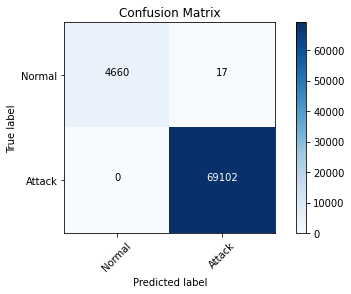

feature importance:
('Length', 0.46326503629917104)
('is_HTTP', 0.16977930285881035)
('dT', 0.08217849038584094)
('is_UDP', 0.06794828287679282)
('is_TCP', 0.05903836446422484)
('is_OTHER', 0.05764505204310009)
('dT2', 0.019887555011020273)
('dT3', 0.013273612029839562)
*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)


In [28]:
run_classification(all_features, all_labels)

## Thought Questions

1. How did the performance of the standard machine learning classifiers compare to the more conventional ML models? Why?
2. How did the training and testing time compare for each of these models? Which ones are most efficient?
3. Based on what you see, what might be the advantages and disadvantages of machine learning models for network inference and prediction tasks, in practice?